In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import xarray as xr
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from data_visualization.r2t_vis import plot_chart_data, plot_img_band

In [2]:
fp = '../data/r2t/train/20180607T184326_dmi_prep.nc'

output_dir = '../output'

data = xr.open_dataset(fp)
data

<xarray.Dataset> Size: 498MB
Dimensions:               (sar_lines: 4999, sar_samples: 5213,
                           sar_sample_2dgrid_points: 21,
                           sar_line_2dgrid_points: 21, 2km_grid_lines: 199,
                           2km_grid_samples: 208)
Dimensions without coordinates: sar_lines, sar_samples,
                                sar_sample_2dgrid_points,
                                sar_line_2dgrid_points, 2km_grid_lines,
                                2km_grid_samples
Data variables: (12/29)
    SIC                   (sar_lines, sar_samples) uint8 26MB ...
    SOD                   (sar_lines, sar_samples) uint8 26MB ...
    FLOE                  (sar_lines, sar_samples) uint8 26MB ...
    sar_grid2d_latitude   (sar_sample_2dgrid_points, sar_line_2dgrid_points) float64 4kB ...
    sar_grid2d_longitude  (sar_sample_2dgrid_points, sar_line_2dgrid_points) float64 4kB ...
    nersc_sar_primary     (sar_lines, sar_samples) float32 104MB ...
    ...                    ...
    u10m_rotated          (2km_grid_lines, 2km_grid_samples) float32 166kB ...
    v10m_rotated          (2km_grid_lines, 2km_grid_samples) float32 166kB ...
    t2m                   (2km_grid_lines, 2km_grid_samples) float32 166kB ...
    skt                   (2km_grid_lines, 2km_grid_samples) float32 166kB ...
    tcwv                  (2km_grid_lines, 2km_grid_samples) float32 166kB ...
    tclw                  (2km_grid_lines, 2km_grid_samples) float32 166kB ...
Attributes:
    scene_id:       20180607T184326_dmi_prep.nc
    original_id:    S1B_EW_GRDM_1SDH_20180607T184326_20180607T184426_011271_0...
    ice_service:    dmi
    flip:           0
    pixel_spacing:  80

In [3]:
# --- Load the data --- #
data = xr.open_dataset(fp)

HH = data.nersc_sar_primary
HV = data.nersc_sar_secondary
IA = data.sar_incidenceangle
HH_masked = HH.where(HH != 0)
HV_masked = HV.where(HV != 0)
IA_masked = IA.where(IA != 0)

SIC = data.SIC
SOD = data.SOD
FLOE = data.FLOE

# close figure and data to avoid memory leak and consumption
data.close()

# Set land values to NaN, but keep other 255 values
# (representing nodata values on the charts)
land_indcs = (HH == 0) & (SIC == 255)
sod_masked = SOD.where(~land_indcs)
sic_masked = SIC.where(~land_indcs)
floe_masked = FLOE.where(~land_indcs)

# convert into numpy array
sic_np = sic_masked.values

# Replace NaN values with -1
sic_np_rm_nan = np.nan_to_num(sic_np, nan=-1)

print("sic_np_rm_nan shape: ", sic_np_rm_nan.shape)
print("sic_np_rm_nan range: ", sic_np_rm_nan.min(), "-", sic_np_rm_nan.max())

sic_np_rm_nan shape:  (4999, 5213)
sic_np_rm_nan range:  -1.0 - 10.0


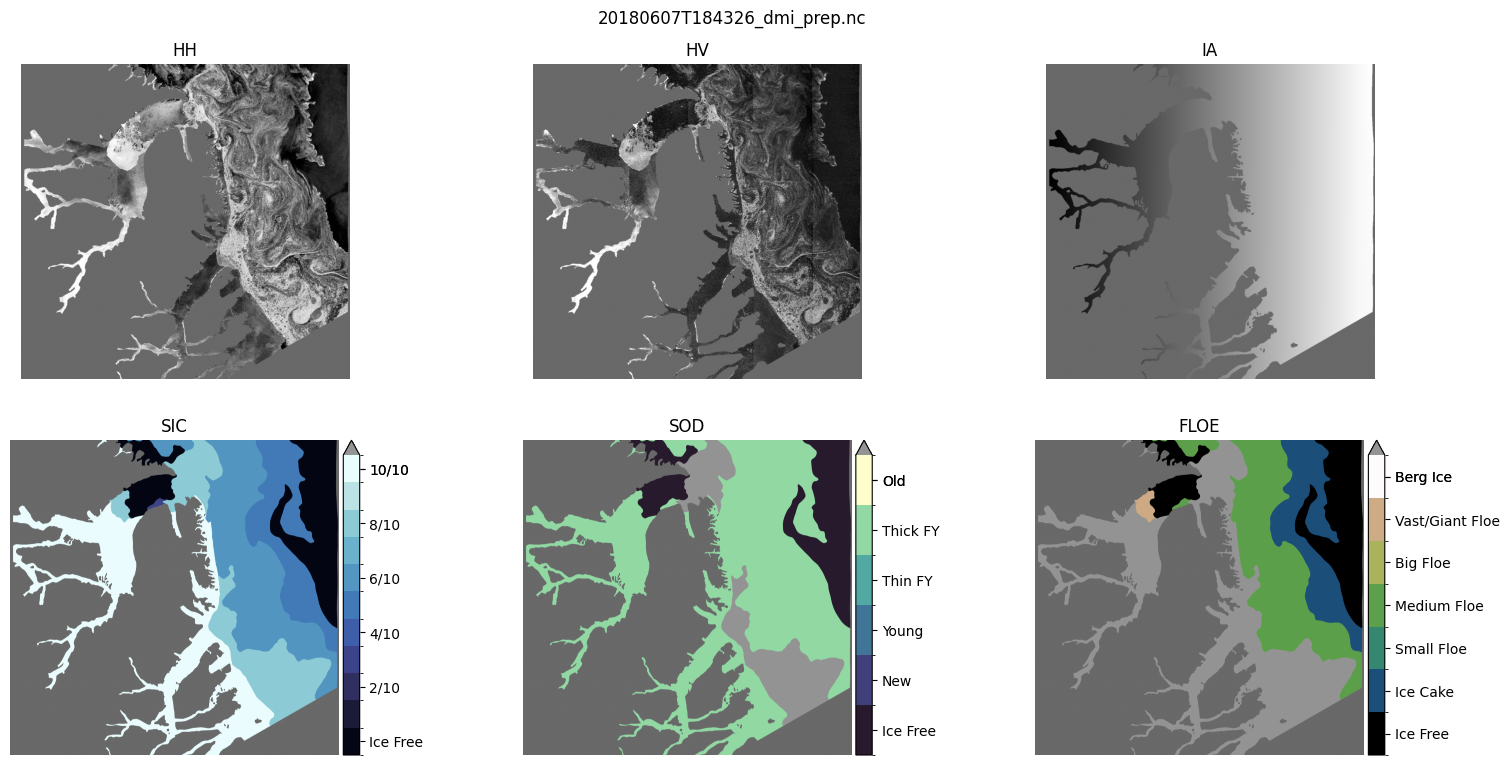

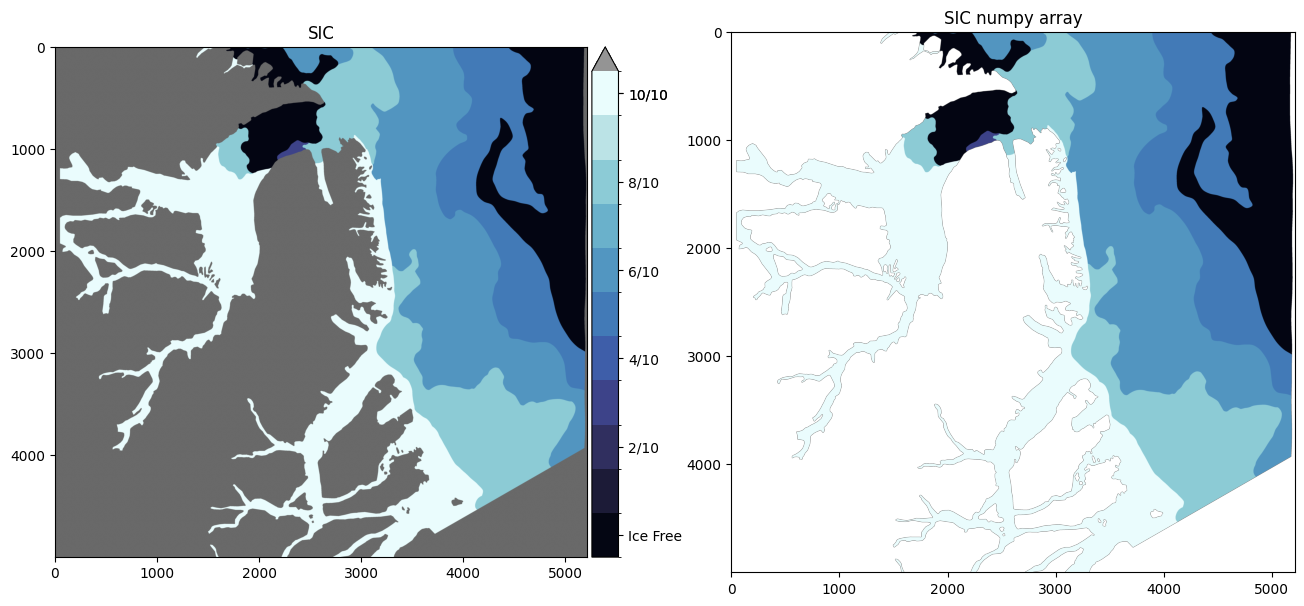

In [4]:
# r2t data visualization
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

plot_img_band(HH_masked[::4, ::4], axs[0, 0], clip=True)
axs[0, 0].set_title("HH")
plot_img_band(HV_masked[::4, ::4], axs[0, 1], clip=True)
axs[0, 1].set_title("HV")
plot_img_band(IA_masked[::4, ::4], axs[0, 2], clip=False)
axs[0, 2].set_title("IA")

plot_chart_data(sic_masked, 'SIC', fig, axs[1, 0],
                cm=cmocean.cm.ice, cbar_tick_spacing=2)
plot_chart_data(sod_masked, 'SOD', fig, axs[1, 1],
                cm=cmocean.cm.deep.reversed())
plot_chart_data(floe_masked, 'FLOE', fig, axs[1, 2],
                cm=mpl.colormaps['gist_earth'])

plt.suptitle(fp.split('/')[-1])

fig.tight_layout()
for r in axs:
    for ax in r:
        ax.axis('off')
plt.show()


# SIC data visualization using plot_chart_data and plain numpy
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

plot_chart_data(sic_masked, "SIC", fig, axs[0], cm=cmocean.cm.ice, cbar_tick_spacing=2)

# plot sic_np
axs[1].imshow(sic_np, cmap=cmocean.cm.ice)
axs[1].set_title("SIC numpy array")
plt.show()

In [5]:
# # Calculating std using numpy std(), super slow!!!
# from scipy.ndimage import generic_filter

# # Define the standard deviation filter function
# def std_filter(x):
#     return np.std(x)

# # Apply the filter to the image. Kernel size is 5x5
# std_5_np = generic_filter(sic_np_rm_nan, std_filter, size=5)

# # Plot the filtered image
# fig = plt.figure(figsize=(15, 10))
# plt.imshow(std_5_np, cmap='gray')
# plt.colorbar()
# plt.savefig(os.path.join(output_dir, "std_5_np.png"))
# plt.show()

# # Binarize the image
# std_5_np_b = std_5_np != 0

# # Plot the binarized image
# fig = plt.figure(figsize=(15, 10))
# plt.imshow(std_5_np_b, cmap='gray')
# plt.colorbar()
# plt.savefig(os.path.join(output_dir, "std_5_np_b.png"))
# plt.show()

In [8]:
import torch
import torch.nn.functional as F

def compute_local_std(sic_np, kernel_size, device):
    # Convert input to PyTorch tensor and move to GPU
    sic_torch = torch.tensor(sic_np, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

    # Define kernel and padding
    padding = kernel_size // 2
    mean_kernel = torch.ones((1, 1, kernel_size, kernel_size), dtype=torch.float32, device=device) / (kernel_size * kernel_size)

    # Compute mean of 5x5 patches
    mean = F.conv2d(sic_torch, mean_kernel, padding=padding)

    # Compute mean of squared values
    mean_of_squares = F.conv2d(sic_torch**2, mean_kernel, padding=padding)

    # Compute variance and standard deviation
    # variance = E[x^2] - (E[x])^2
    variance = mean_of_squares - mean**2

    std = torch.sqrt(variance)
    std[torch.isnan(std)] = 0

    # Move back to CPU and convert to NumPy
    return std.squeeze().cpu().numpy()

def binarize_image(image, threshold, device):
    # Convert input to PyTorch tensor and move to GPU
    image_torch = torch.tensor(image, dtype=torch.float32, device=device)

    # Binarize the image
    image_b = image_torch > threshold

    return image_b.cpu().numpy()

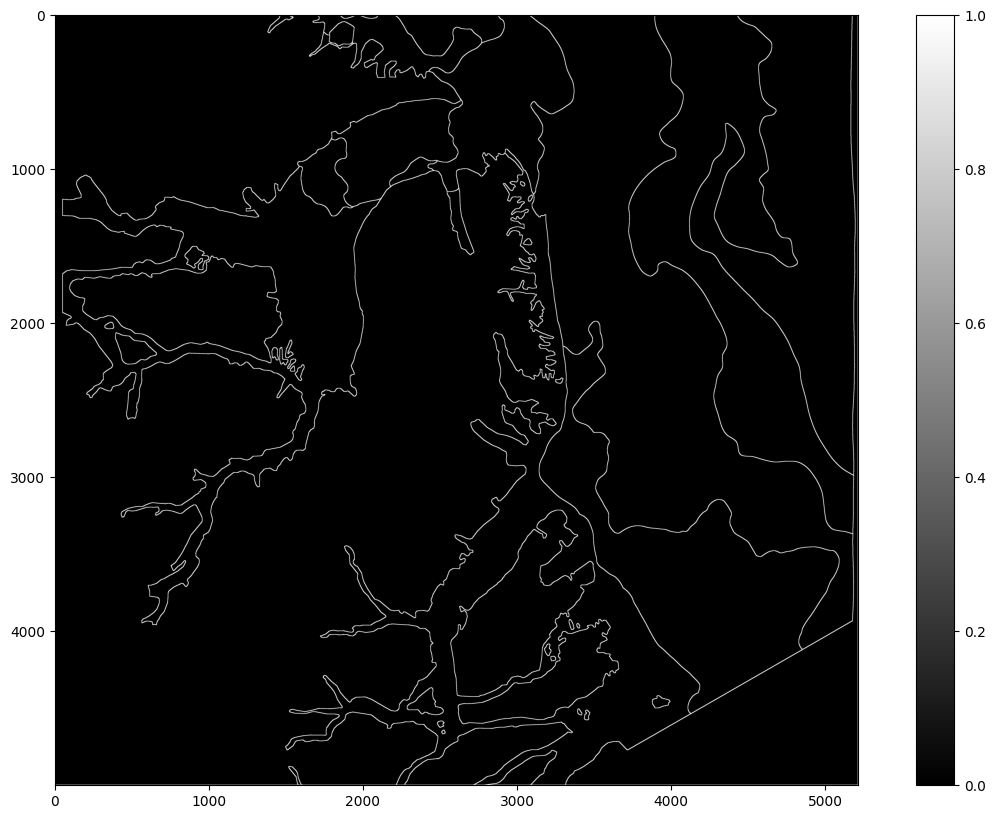

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move back to CPU for visualization
std_5_torch = compute_local_std(sic_np=sic_np_rm_nan, kernel_size=5, device=device)

std_5_torch_b = binarize_image(std_5_torch, threshold=0.1, device=device)

# Plot the binarized image
fig = plt.figure(figsize=(15, 10))
plt.imshow(std_5_torch_b, cmap='gray')
plt.colorbar()
plt.savefig(os.path.join(output_dir, "std_5_torch_b.png"))
plt.show()

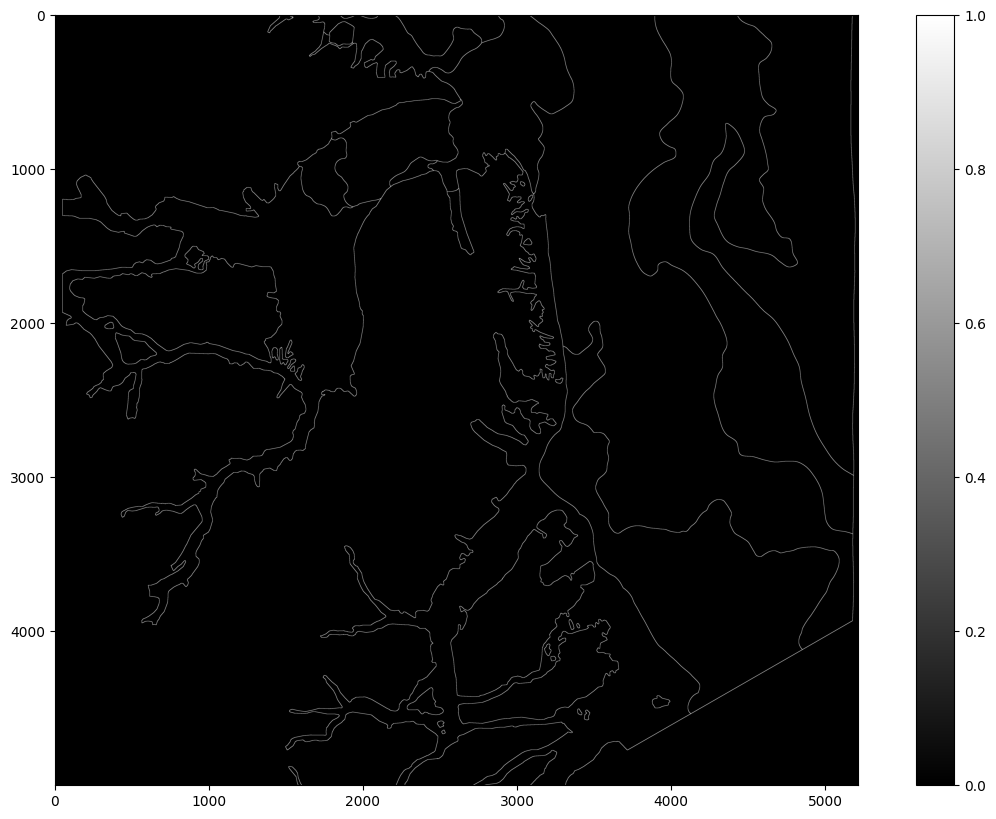

In [20]:
# Edge Detection (Sobel / Canny)
import cv2

# Apply Sobel edge detection (to highlight boundaries)
sobel_x = cv2.Sobel(sic_np_rm_nan, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(sic_np_rm_nan, cv2.CV_64F, 0, 1, ksize=3)
edges = np.hypot(sobel_x, sobel_y)  # Compute gradient magnitude

# Normalize and threshold edges
# edges_sobel = (edges > 0).astype(np.uint8) * 255
edges_sobel = edges > 0

# Plot the edge-detected image
fig = plt.figure(figsize=(15, 10))
plt.imshow(edges_sobel, cmap='gray')
plt.colorbar()
plt.savefig(os.path.join(output_dir, "edges_sobel.png"))
plt.show()